## Setup

In [1]:
import utils
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import chardet

In [2]:
# Allowing reproducibility
random_seed = 42
np.random.seed(random_seed)

## Dataset Loading

In [3]:
dataset_path = '/Users/kor/Downloads/Adecco_Dataset/direct_matching_20240213_eng.csv'

In [4]:
with open(dataset_path, 'rb') as f:
    result = chardet.detect(f.read())
    encoding = result['encoding']


In [5]:
df = pd.read_csv(dataset_path, delimiter=';', encoding=encoding)

## Data Preparation

We have to carefully prepare the dataset for classification avoiding <b>sample bias</b>, i.e., avoiding that the negative examples are biased. Note: we cannot do anything for an eventual bias in the hiring process (when we pick the top-1 candidate), and it would be incorrect too since our task is focusing on that kind of bias.

In [6]:
df.head(11)

,cand_id,job_id,distance_km,match_score,match_rank,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,cand_education,job_contract_type,job_professional_category,job_sector,job_work_province
0,"5,664,912",OFF_1011_1427,3.232.704.163,9.957.338.715,1,Male,45-54,UD,FRIULI VENEZIA GIULIA,NaN,Subordinate employment,Surveying and technician of civil and industri...,Designers / Design / Graphics,UD
1,"4,999,120",OFF_1011_1427,155.955.925,9.921.056.366,2,Male,35-44,UD,FRIULI VENEZIA GIULIA,NaN,Subordinate employment,Surveying and technician of civil and industri...,Designers / Design / Graphics,UD
2,"5,413,671",OFF_1011_1427,3.134.887.695,991.186.142,3,Female,45-54,UD,FRIULI VENEZIA GIULIA,NaN,Subordinate employment,Surveying and technician of civil and industri...,Designers / Design / Graphics,UD
3,"5,965,090",OFF_1011_1427,6.631.559.753,9.740.976.715,4,Male,15-24,TS,FRIULI VENEZIA GIULIA,NaN,Subordinate employment,Surveying and technician of civil and industri...,Designers / Design / Graphics,UD
4,"5,771,219",OFF_1011_1427,155.955.925,9.732.387.543,5,Female,35-44,UD,FRIULI VENEZIA GIULIA,NaN,Subordinate employment,Surveying and technician of civil and industri...,Designers / Design / Graphics,UD
5,"2,216,205",OFF_1011_1427,2.494.693.947,969.223.175,6,Male,55-74,UD,FRIULI VENEZIA GIULIA,Degree / High School : Surveying,Subordinate employment,Surveying and technician of civil and industri...,Designers / Design / Graphics,UD
6,"4,594,051",OFF_1011_1427,2.795.996.857,9.624.521.637,7,Male,55-74,UD,FRIULI VENEZIA GIULIA,NaN,Subordinate employment,Surveying and technician of civil and industri...,Designers / Design / Graphics,UD
7,"5,148,878",OFF_1011_1427,2.551.218.033,9.623.524.475,8,Male,25-34,UD,FRIULI VENEZIA GIULIA,NaN,Subordinate employment,Surveying and technician of civil and industri...,Designers / Design / Graphics,UD
8,"5,933,345",OFF_1011_1427,288.568.325,9.600.971.222,9,Female,45-54,GO,FRIULI VENEZIA GIULIA,NaN,Subordinate employment,Surveying and technician of civil and industri...,Designers / Design / Graphics,UD
9,"7,204,128",OFF_1011_1427,3.134.887.695,9.580.227.661,10,Female,35-44,UD,FRIULI VENEZIA GIULIA,NaN,Subordinate employment,Surveying and technician of civil and industri...,Designers / Design / Graphics,UD


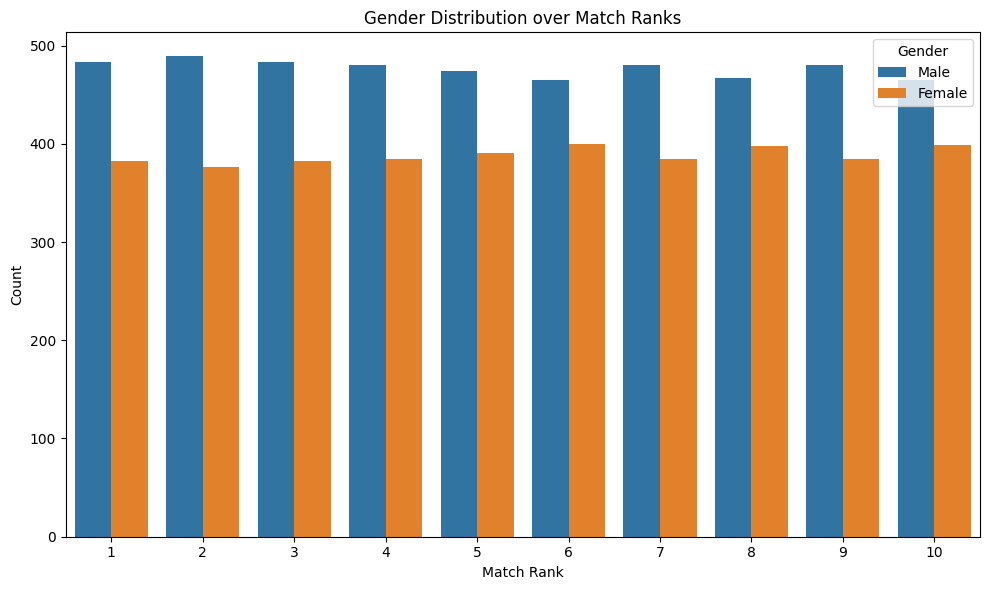

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='match_rank', hue='cand_gender', order=range(1, 11))
plt.title('Gender Distribution over Match Ranks')
plt.xlabel('Match Rank')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()


Each rank reflects the hiring process unbalance, therefore the choice is arbitrary. We will chose the rank which mostly limits this sample bias, i.e., rank 6.

In [8]:
hired_rank = 1
negative_samples_rank = 6

In [9]:
df1 = df[df['match_rank'].isin([hired_rank,negative_samples_rank])].copy()
df1 = df1.reset_index(drop=True)

In [10]:
df1['hired'] = (df1['match_rank'] == hired_rank).astype(int)

In [11]:
target_feature = 'hired'

Both the match rank and the match score are useless now that we extract the label, so we can drop them.

In [12]:
df1.drop(['match_score','match_rank'], axis=1, inplace=True)

In [13]:
df1.head()

,cand_id,job_id,distance_km,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,cand_education,job_contract_type,job_professional_category,job_sector,job_work_province,hired
0,"5,664,912",OFF_1011_1427,3.232.704.163,Male,45-54,UD,FRIULI VENEZIA GIULIA,NaN,Subordinate employment,Surveying and technician of civil and industri...,Designers / Design / Graphics,UD,1
1,"2,216,205",OFF_1011_1427,2.494.693.947,Male,55-74,UD,FRIULI VENEZIA GIULIA,Degree / High School : Surveying,Subordinate employment,Surveying and technician of civil and industri...,Designers / Design / Graphics,UD,0
2,"5,025,089",OFF_1038_1739,1.778.607.559,Male,25-34,MI,LOMBARDIA,Degree / High School : Scientific High School,Search and selection,Butcher (m/f),Large-scale distribution / Retail / Shop assis...,MI,1
3,"6,111,549",OFF_1038_1739,1.818.578.529,Female,45-54,BG,LOMBARDIA,NaN,Search and selection,Butcher (m/f),Large-scale distribution / Retail / Shop assis...,MI,0
4,"7,090,323",OFF_104_1550,2.166.576.576,Male,35-44,CH,ABRUZZO,NaN,Subordinate employment,welder,Specialized workers,CH,1


## Data Preprocessing

Before continuing with the data analysis we want to ensure that missing values are handled correctly and the data are ready to be feed in a classifier. Let's inspect some of their statistics.

In [14]:
print(f'Examples in the dataset: {df1.shape[0]}')

Examples in the dataset: 1730


In [15]:
df1.describe(include='all')

,cand_id,job_id,distance_km,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,cand_education,job_contract_type,job_professional_category,job_sector,job_work_province,hired
count,1730,1730,1730,1730,1730,1729,1728,458,1730,1730,1730,1730,1730.000000
unique,1532,865,1080,2,5,71,16,161,3,247,26,53,NaN
top,"7,008,813",OFF_1011_1427,0,Male,25-34,MI,LOMBARDIA,Middle School,Subordinate employment,General Metalworker,General Workers,MI,NaN
freq,7,2,119,948,581,278,794,84,1132,154,566,338,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500145
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


Most of the variables doen't miss any value, except for the <b>candidate domicile province</b> which misses just one value, the <b>candidate domicile region</b> which misses only two values and the <b>candidate education</b>, which instead misses way more values. We can account for the 3 missing  values by simply drop the related rows, but we must find a default value for the education since the rows containing missing values are too much.

In [16]:
df1 = df1[~df1['cand_domicile_province'].isnull()]
df1 = df1[~df1['cand_domicile_region'].isnull()]

In general, we can keep all the numerical values, but we have to account for the categorical ones in order to feed a classifier. In the next paragraphs we will focus on the features that require our attention.

### IDs

Candidate id and job id are meaningless for the task of bias detection, hence we can easily drop them.

In [17]:
df1.drop(['cand_id','job_id'], axis=1, inplace=True)

### Distance Km

In [18]:
df1['distance_km'].describe()

count     1727
unique    1078
top          0
freq       119
Name: distance_km, dtype: object

In [19]:
df1.head()['distance_km']

0    3.232.704.163
1    2.494.693.947
2    1.778.607.559
3    1.818.578.529
4    2.166.576.576
Name: distance_km, dtype: object

They are in the form "km.meters", so we need to process them

In [20]:
def parse_distance_km(s):
    parts = s.split('.')
    if len(parts) == 4:
        return int(parts[0])
    return 0

In [21]:
df1['distance_km'] = df1['distance_km'].apply(parse_distance_km)

In [22]:
df1['distance_km'].describe()

count    1727.000000
mean        3.038217
std         2.638677
min         0.000000
25%         1.000000
50%         2.000000
75%         5.000000
max         9.000000
Name: distance_km, dtype: float64

First of all, let's inspect the distribution.

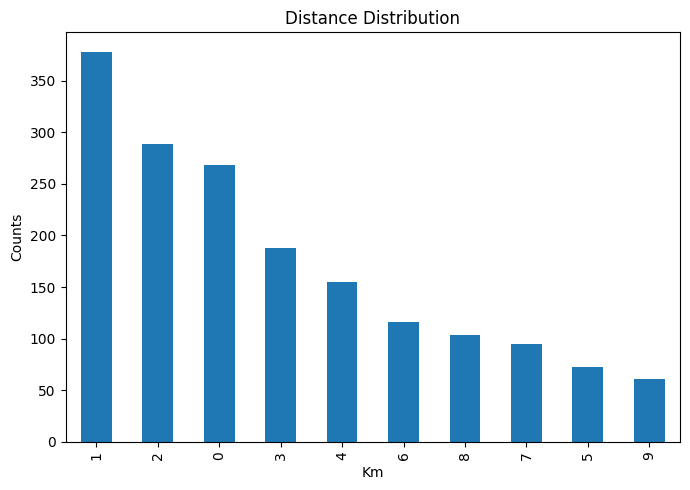

In [23]:
# Visualize the distribution
plt.figure(figsize=(7, 5))
df1['distance_km'].value_counts().plot(kind='bar')
plt.xlabel('Km')
plt.ylabel('Counts')
plt.title('Distance Distribution')
plt.tight_layout()
plt.show()

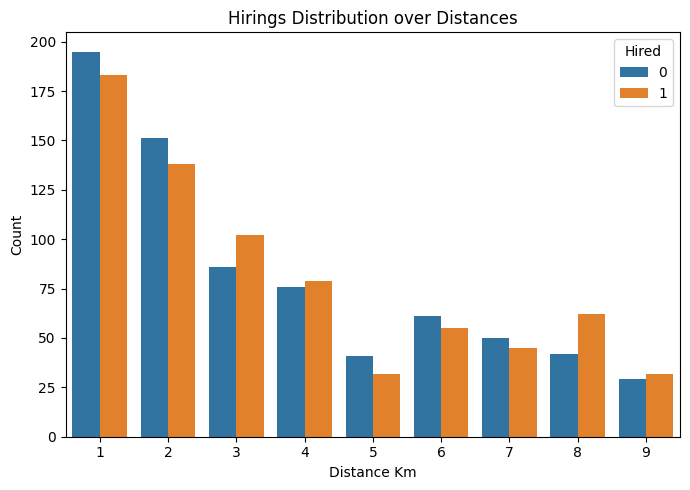

In [24]:
plt.figure(figsize=(7, 5))
sns.countplot(data=df1, x='distance_km', hue='hired', order=range(1, 10))
plt.title('Hirings Distribution over Distances')
plt.xlabel('Distance Km')
plt.ylabel('Count')
plt.legend(title='Hired')
plt.tight_layout()
plt.show()

There is no particular bias related to this feature. The fact that the hired counts per distance are not uniform is probably due to other factors.

### Candidate Gender

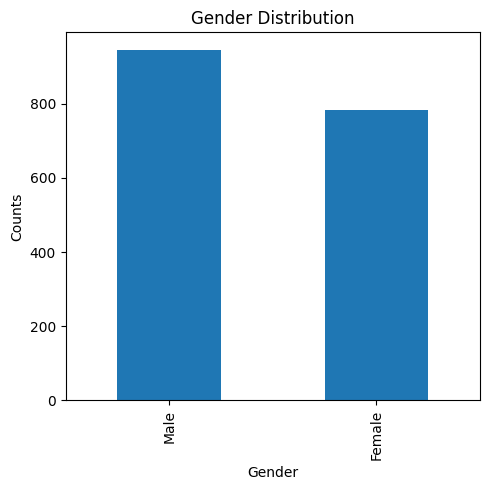

In [25]:
# Visualize the distribution
plt.figure(figsize=(5, 5))
df1['cand_gender'].value_counts().plot(kind='bar')
plt.xlabel('Gender')
plt.ylabel('Counts')
plt.title('Gender Distribution')
plt.tight_layout()
plt.show()

The dataset is imbalanced, but this tell us nothing about any possible bias or unfairness. In order to spot any kind of unfairness we should compare this distribution with the hirings.

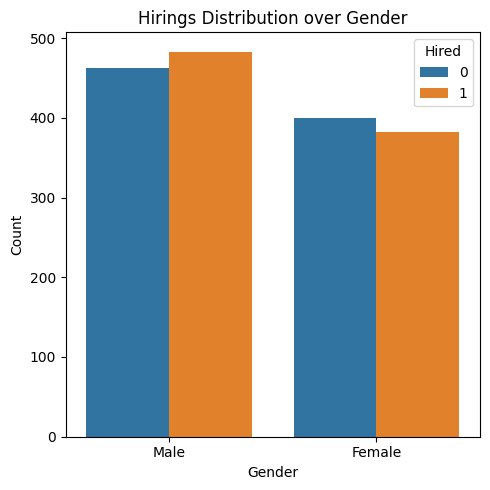

In [26]:
plt.figure(figsize=(5, 5))
sns.countplot(data=df1, x='cand_gender', hue='hired')
plt.title('Hirings Distribution over Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Hired')
plt.tight_layout()
plt.show()

Here we can spot a little bias, despite the distribution of genders is not uniform. We should compare this property with the other features in order to spot the various biases (in job sectors for instance).

/var/folders/2q/rkhrm2kx3679lsk08jhspf5w0000gn/T/ipykernel_5632/2447641889.py:7: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


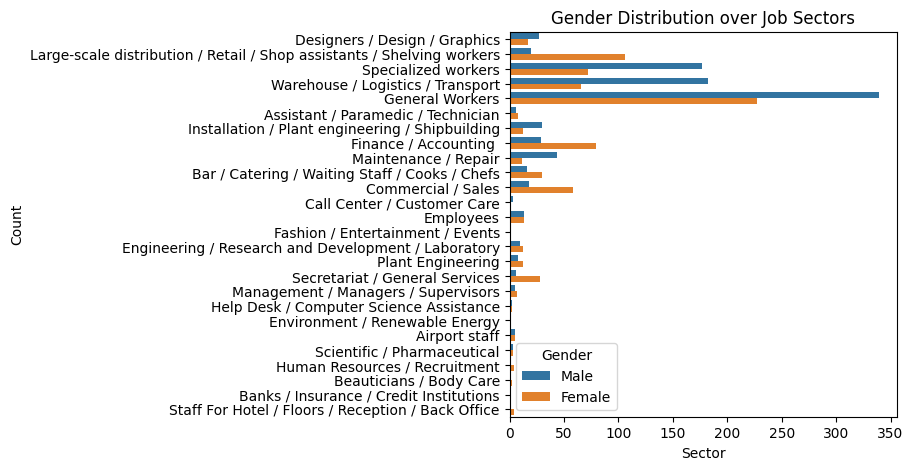

In [27]:
plt.figure(figsize=(5, 5))
sns.countplot(data=df1, y='job_sector', hue='cand_gender')
plt.title('Gender Distribution over Job Sectors')
plt.xlabel('Sector')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

It is evident that there is some bias related to the gender in most of the sectors, so we mark it as sensitive.

In [28]:
sensitive_features = ['cand_gender']

In [29]:
# Preprocessing
df1['cand_gender'] = df1['cand_gender'].apply(lambda s: int(str.lower(s) == 'male'))

### Candidate Province

In [30]:
df1['cand_domicile_province'].describe()

count     1727
unique      70
top         MI
freq       278
Name: cand_domicile_province, dtype: object

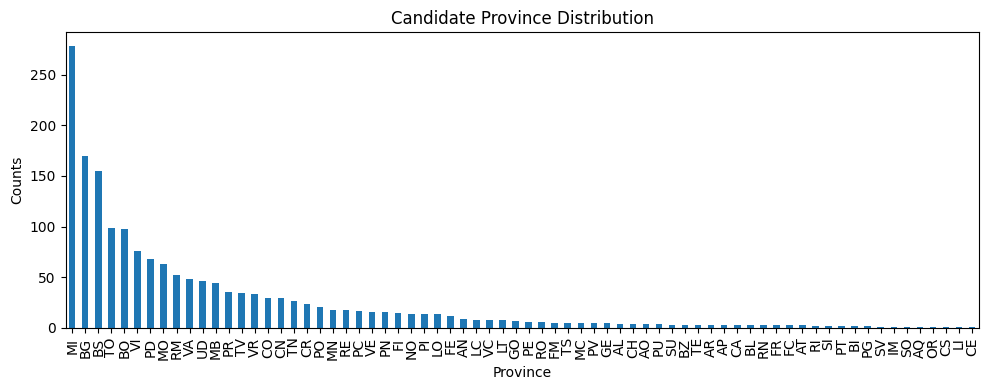

In [31]:
# Visualize the distribution
plt.figure(figsize=(10, 4))
df1['cand_domicile_province'].value_counts().plot(kind='bar')
plt.xlabel('Province')
plt.ylabel('Counts')
plt.title('Candidate Province Distribution')
plt.tight_layout()
plt.show()

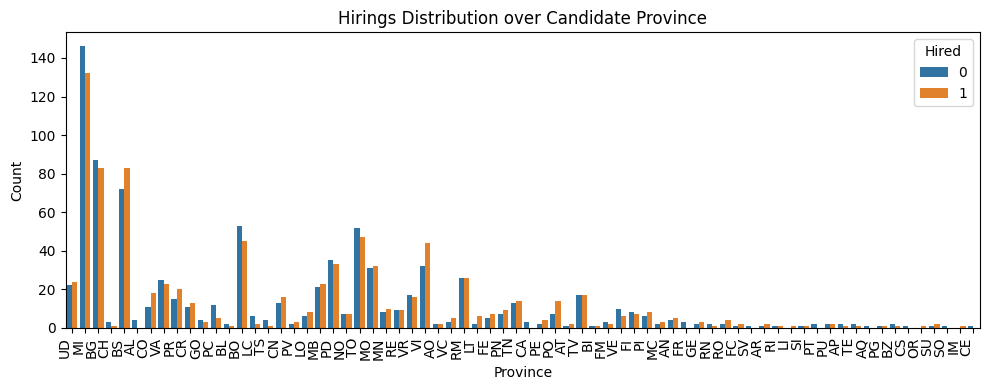

In [32]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df1, x='cand_domicile_province', hue='hired')
plt.title('Hirings Distribution over Candidate Province')
plt.xlabel('Province')
plt.ylabel('Count')
plt.legend(title='Hired')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

This comparison doesn't make so much sense alone.

In order to preprocess this feature, we have to ensure that even the job work province will be coherent with the candidate province, therefore we will build a map to encode them.

In [33]:
def get_province_encoding_map():
    i = 0
    province_to_idx = dict()
    for p in df1['cand_domicile_province']:
        p = str.strip(p)
        if p not in province_to_idx:
            province_to_idx[p] = i
            i += 1
    for p in df1['job_work_province']:
        p = str.strip(p)
        if p not in province_to_idx:
            province_to_idx[p] = i
            i += 1
    return province_to_idx

In [34]:
province_to_idx = get_province_encoding_map()
df1['cand_domicile_province'] = df1['cand_domicile_province'].apply(lambda p : province_to_idx[str.strip(p)])

### Domicile Region

In [35]:
df1['cand_domicile_region'].describe()

count          1727
unique           16
top       LOMBARDIA
freq            794
Name: cand_domicile_region, dtype: object

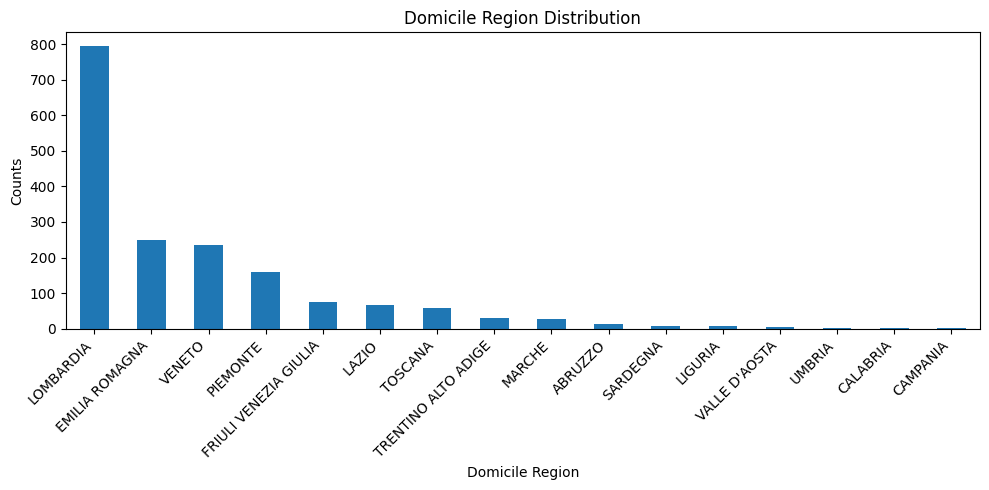

In [36]:
# Visualize the distribution
plt.figure(figsize=(10, 5))
df1['cand_domicile_region'].value_counts().plot(kind='bar')
plt.xlabel('Domicile Region')
plt.ylabel('Counts')
plt.title('Domicile Region Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

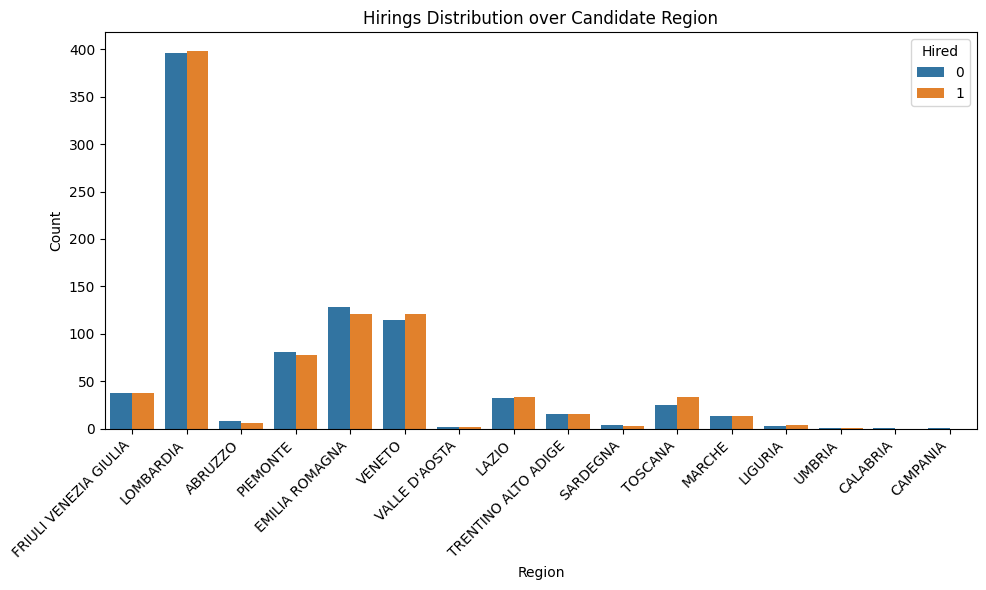

In [37]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df1, x='cand_domicile_region', hue='hired')
plt.title('Hirings Distribution over Candidate Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.legend(title='Hired')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

This last plot shows that there are no biases in the region, thus we can assume that there are no bias in the province feature too. Note that the regions of the south are not well represented, so any bias related to the north-south discrimination won't be catched.

A one-hot wencoding would be too heavy for too much regions, thus we can group them into south, central and north regions and then one-hot encode them.

In [38]:
region_groups = {
    # North
    'piemonte': 'north',
    'valle d\'aosta': 'north',
    'lombardia': 'north',
    'veneto': 'north',
    'friuli venezia giulia': 'north',
    'liguria': 'north',
    'emilia romagna': 'north',
    'trentino alto adige': 'north',

    # Central
    'toscana': 'central',
    'umbria': 'central',
    'marche': 'central',
    'lazio': 'central',

    # South
    'abruzzo': 'south',
    'molise': 'south',
    'campania': 'south',
    'puglia': 'south',
    'basilicata': 'south',
    'calabria': 'south',

    # Islands
    'sicilia': 'south',
    'sardegna': 'south'
}

In [39]:
df1['cand_domicile_region'] = df1['cand_domicile_region'].apply(lambda r : region_groups[str.lower(r)])

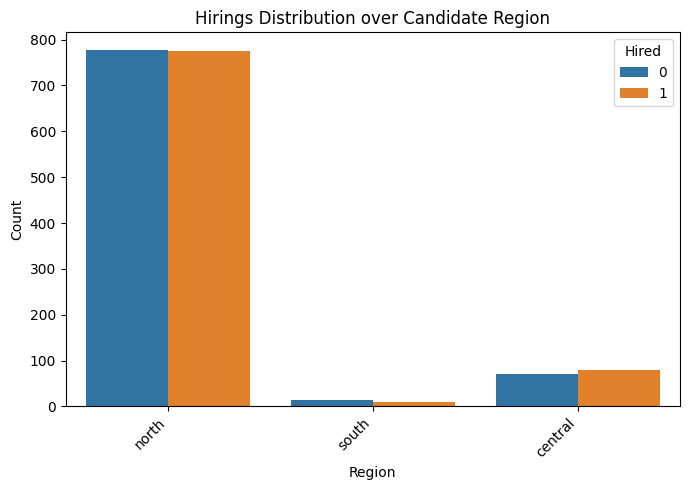

In [40]:
plt.figure(figsize=(7, 5))
sns.countplot(data=df1, x='cand_domicile_region', hue='hired')
plt.title('Hirings Distribution over Candidate Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.legend(title='Hired')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [41]:
df1 = pd.get_dummies(df1, columns=['cand_domicile_region'], prefix='region', drop_first=False, dtype=int)

### Age Buckets

In [42]:
df1['cand_age_bucket'].unique()

array(['45-54', '55-74', '25-34', '35-44', '15-24'], dtype=object)

In [43]:
print(f"Null age buckets: {df1['cand_age_bucket'].isnull().sum()}")

Null age buckets: 0


Since it is only one we can safely drop it.

In [44]:
df1['cand_age_bucket'].value_counts()

cand_age_bucket
25-34    580
35-44    434
45-54    366
55-74    186
15-24    161
Name: count, dtype: int64

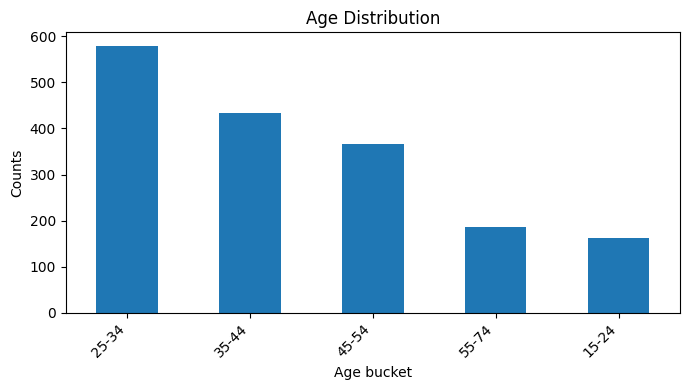

In [45]:
plt.figure(figsize=(7, 4))
df1['cand_age_bucket'].value_counts().plot(kind='bar')
plt.xlabel('Age bucket')
plt.ylabel('Counts')
plt.title('Age Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

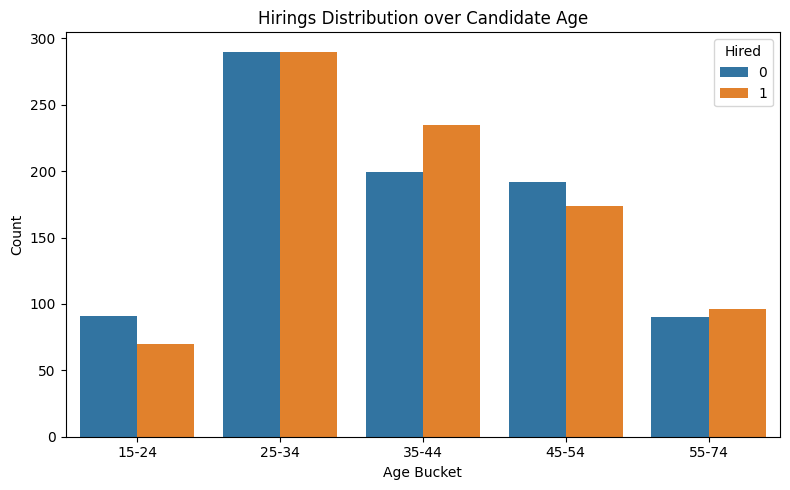

In [46]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df1, x='cand_age_bucket', hue='hired', order=['15-24', '25-34', '35-44', '45-54', '55-74'])
plt.title('Hirings Distribution over Candidate Age')
plt.xlabel('Age Bucket')
plt.ylabel('Count')
plt.legend(title='Hired')
plt.tight_layout()
plt.show()

Here we can spot a bias too. The most evident disparities are between the young people and the mid-aged (35-44). The latter are clearly preferred (maybe due to experience-age tradeoff), while the former might be discarded due to their little experience, so we decides to mark this feature as sensitive too.

In [47]:
sensitive_features.append('cand_age_bucket')

We can discretize them since they are numerical but preserves the order, thus a progressive enumeration makes sense.

In [48]:
age_bucket_order = {
    '15-24': 0,
    '25-34': 1,
    '35-44': 2,
    '45-54': 3,
    '55-74': 4,
}

df1['cand_age_bucket'] = df1['cand_age_bucket'].map(age_bucket_order).astype(int)

In [49]:
df1['cand_age_bucket'].value_counts()

cand_age_bucket
1    580
2    434
3    366
4    186
0    161
Name: count, dtype: int64

### Candidate Education

In [50]:
def map_education_level(x):
    if pd.isna(x):
        return 'Unknown'
    x = str(x).lower()

    # Clean common formatting inconsistencies
    x = x.replace('laurea', 'degree')
    x = x.replace('diploma', 'degree')
    
    if 'dottorato' in x or 'phd' in x or 'research doctorate' in x:
        return 'PhD'
    elif 'master' in x or 'lm-' in x:
        return 'Graduate'
    elif 'bachelor' in x or 'l-' in x:
        return 'Undergraduate'
    elif 'higher technical institute' in x or 'its' in x:
        return 'Higher Technical Institute'
    elif 'qualification' in x or 'certificate' in x or 'operator' in x:
        return 'Vocational Certificate'
    elif 'high school' in x or 'liceo' in x or 'technician' in x or 'technical' in x:
        return 'High School'
    elif 'middle school' in x or 'scuola media' in x:
        return 'Middle School'
    elif 'elementary' in x:
        return 'Elementary School'
    else:
        return 'Other'


In [51]:
df1['cand_education'] = df1['cand_education'].apply(map_education_level)

In [52]:
df1['cand_education'].value_counts()

cand_education
Unknown                       1269
High School                    195
Middle School                   85
Vocational Certificate          77
Graduate                        38
Higher Technical Institute      30
Undergraduate                   29
Elementary School                3
PhD                              1
Name: count, dtype: int64

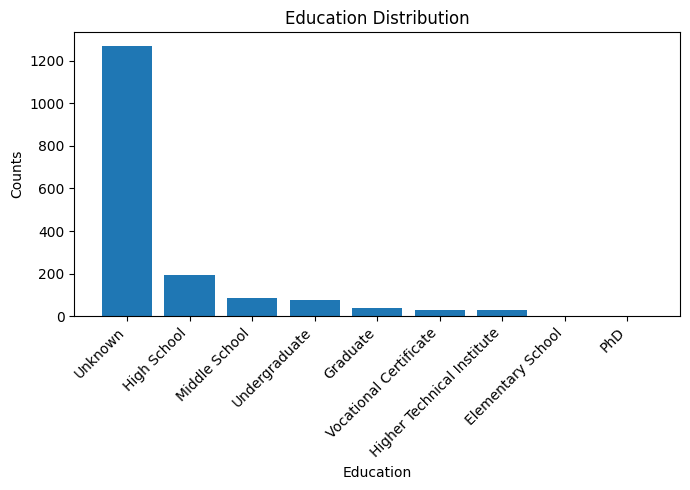

In [53]:
# Visualize the distribution
plt.figure(figsize=(7, 5))
plt.bar(df1['cand_education'].unique(), df1['cand_education'].value_counts())
plt.xlabel('Education')
plt.ylabel('Counts')
plt.title('Education Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

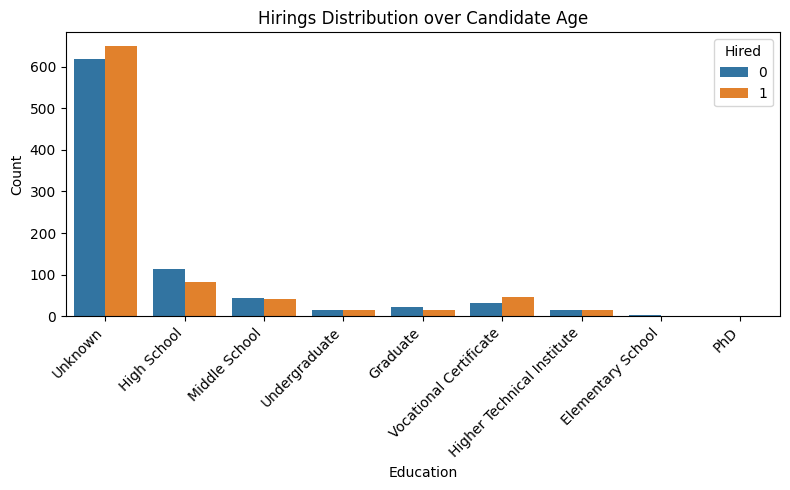

In [54]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df1, x='cand_education', hue='hired')
plt.title('Hirings Distribution over Candidate Age')
plt.xlabel('Education')
plt.ylabel('Count')
plt.legend(title='Hired')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

There might be some bias against the people with an high school instruction, but these results are probably due to random fluctuations and not about the bias. However, we cannot say much looking only at this feature.

In [71]:
df1 = pd.get_dummies(df1, columns=['cand_education'], prefix='education', drop_first=False, dtype=int)

### Job Contract Type

In [56]:
df1['job_contract_type'].describe()

count                       1727
unique                         3
top       Subordinate employment
freq                        1131
Name: job_contract_type, dtype: object

In [57]:
df1['job_contract_type'].value_counts()

job_contract_type
Subordinate employment    1131
Search and selection       592
Other                        4
Name: count, dtype: int64

since the cardinality of this attribute is low, we can even one-hot encode it. 

In [58]:
df1 = pd.get_dummies(df1, columns=['job_contract_type'], prefix='contract', drop_first=False, dtype=int)

### Job Category

In [59]:
df1['job_professional_category'].describe()

count                    1727
unique                    247
top       General Metalworker
freq                      154
Name: job_professional_category, dtype: object

In [60]:
df1['job_professional_category'].unique()

array(['Surveying and technician of civil and industrial constructions',
       'Butcher (m/f)', 'welder',
       'Head of large-scale retail trade department',
       'Portal truck driver (m/f)', 'warehouse worker',
       'General Construction Worker', 'CNC operator (m/f)', 'Nurse',
       'Metalworking worker', 'O.S.S. (operator social health)',
       'product quality control officer',
       'Mechanic/Toolmaker for welding devices (m/f)',
       'Construction site technician', 'accounting assistant',
       'Home appliance assembly worker (m/f)',
       'Molding machine toolmaker (m/f)', 'Driver',
       'General Manufacturing Worker', 'Assembly worker (m/f)',
       'maintainer', 'Packaging clerk (m/f)',
       'General Service/Tertiary Worker', 'General Rubber/Plastic Worker',
       'Fast Food Attendant', 'Store/branch manager', 'hydraulic',
       'cleaner', 'warehouse employee',
       'Multi-channel customer service operator (sms, web meeting, telephone, email)',
       'Ind

In [61]:
df1['job_professional_category'] = df1['job_professional_category'].apply(lambda category : utils.map_job_category(category))

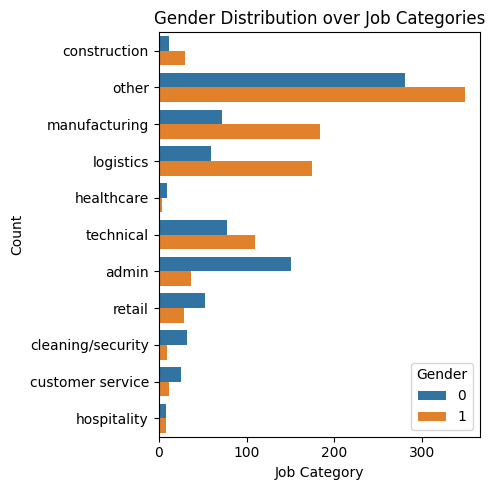

In [62]:
plt.figure(figsize=(5, 5))
sns.countplot(data=df1, y='job_professional_category', hue='cand_gender')
plt.title('Gender Distribution over Job Categories')
plt.xlabel('Job Category')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

Here it is more clear how much this dataset is biased against the gender.

In [63]:
df1 = pd.get_dummies(df1, columns=['job_professional_category'], prefix='category', drop_first=False, dtype=int)

### Job Sector

In [64]:
df1['job_sector'].describe()

count                1727
unique                 26
top       General Workers
freq                  566
Name: job_sector, dtype: object

/var/folders/2q/rkhrm2kx3679lsk08jhspf5w0000gn/T/ipykernel_5632/1570199394.py:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


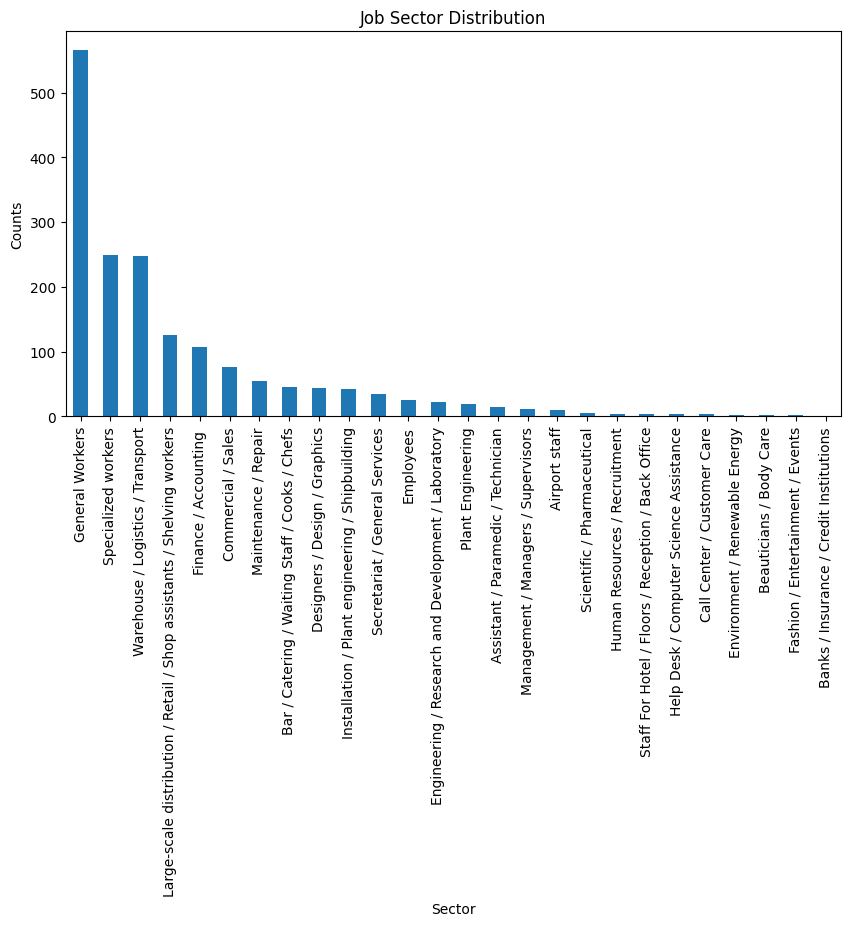

In [65]:
# Visualize the distribution
plt.figure(figsize=(10, 5))
df1['job_sector'].value_counts().plot(kind='bar')
plt.xlabel('Sector')
plt.ylabel('Counts')
plt.title('Job Sector Distribution')
plt.tight_layout()
plt.show()

In [66]:
df1 = pd.get_dummies(df1, columns=['job_sector'], prefix='sector', drop_first=False, dtype=int)

### Job Work Province

In [67]:
df1['job_work_province'].describe()

count     1727
unique      53
top        MI 
freq       338
Name: job_work_province, dtype: object

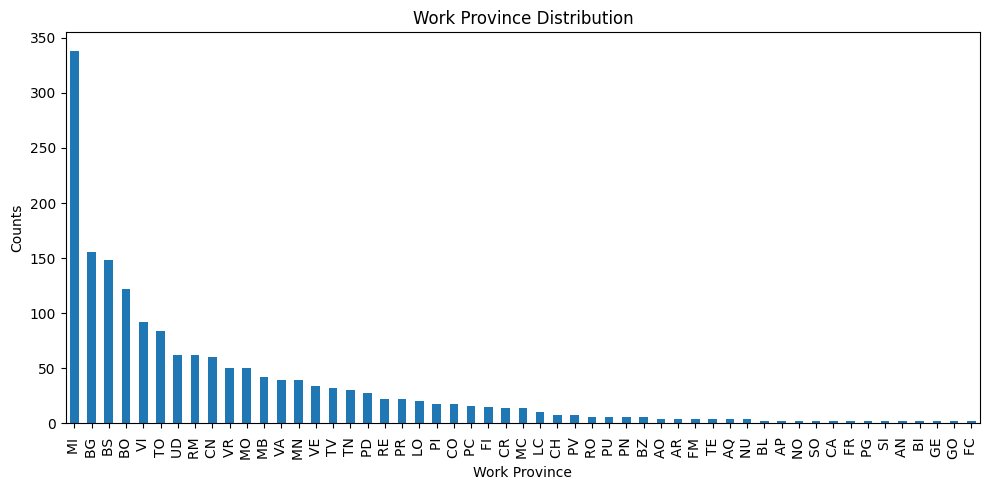

In [68]:
# Visualize the distribution
plt.figure(figsize=(10, 5))
df1['job_work_province'].value_counts().plot(kind='bar')
plt.xlabel('Work Province')
plt.ylabel('Counts')
plt.title('Work Province Distribution')
plt.tight_layout()
plt.show()

In [69]:
df1['job_work_province'] = df1['job_work_province'].apply(lambda p : province_to_idx[str.strip(p)])

### Considerations

We check the statistics of the dataset after the preprocessing

In [72]:
df1.describe(include='all')

,distance_km,cand_gender,cand_age_bucket,cand_domicile_province,job_work_province,hired,region_central,region_north,region_south,contract_Other,...,sector_Warehouse / Logistics / Transport,education_Elementary School,education_Graduate,education_High School,education_Higher Technical Institute,education_Middle School,education_PhD,education_Undergraduate,education_Unknown,education_Vocational Certificate
count,1727.000000,1727.000000,1727.000000,1727.000000,1727.000000,1727.000000,1727.000000,1727.000000,1727.000000,1727.000000,...,1727.000000,1727.000000,1727.000000,1727.000000,1727.000000,1727.000000,1727.000000,1727.000000,1727.000000,1727.000000
mean,3.038217,0.547192,1.905038,15.745223,15.136074,0.500869,0.087435,0.899247,0.013318,0.002316,...,0.143602,0.001737,0.022003,0.112913,0.017371,0.049218,0.000579,0.016792,0.734800,0.044586
std,2.638677,0.497912,1.158981,14.606422,14.700861,0.500144,0.282553,0.301088,0.114665,0.048085,...,0.350787,0.041655,0.146737,0.316578,0.130688,0.216386,0.024063,0.128529,0.441567,0.206453
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,2.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,1.000000,2.000000,13.000000,13.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,3.000000,25.000000,25.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,9.000000,1.000000,4.000000,69.000000,70.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As we can observe, there are no more missing values, and the target lable distribution is uniform, thus there is no unbalance.